# LIBRARIES

**Import Libraries**

In [119]:
import json
import random

# DATA CLASS

**Create Classes**

An enum class for sentiment for avoid dealing with the sentiment as strings

In [120]:
class Sentiment :
  NEGATIVE = "NEGATIVE"
  NEUTRAL = "NEUTRAL"
  POSITIVE = "POSITIVE"

A class for review so that various fields of review i.e text , score can be accessed easily rather than using 2D indexing
For example : 

review[1][0] : gives review text for review number 2
review[1][1] : gives score for review number 2

That is why a class is being created so that we dont need to use 2D indexing just review[1].text , review[1].score

In [121]:
class Review:
  def __init__(self, text, score):
      self.text = text
      self.score = score
      self.sentiment = self.get_sentiment()
        
  def get_sentiment(self):
      if self.score <= 2:
            return Sentiment.NEGATIVE
      elif self.score == 3:
            return Sentiment.NEUTRAL
      else: #Score of 4 or 5
            return Sentiment.POSITIVE

In [122]:
class ReviewContainer:
    def __init__(self, reviews):
        self.reviews = reviews
        
    def get_text(self):
        return [x.text for x in self.reviews]
    
    def get_sentiment(self):
        return [x.sentiment for x in self.reviews]
        
    def evenly_distribute(self):
        
        # Stores all negative sentiments as a list
        negative = list(filter(lambda x: x.sentiment == Sentiment.NEGATIVE, self.reviews))
        
        # Stores all positive reviews as a list
        positive = list(filter(lambda x: x.sentiment == Sentiment.POSITIVE, self.reviews))
        
        # Make length of positive and negative reviews same
        positive_shrunk = positive[:len(negative)]
        self.reviews = negative + positive_shrunk
        random.shuffle(self.reviews)

# LOAD DATA

**Load the data from .json File**
Only Review Text and Overall score is needed

In [123]:
# file_name = '../datasets/books_dataset.json'

file_name = '../datasets/books_dataset1.json'

reviews = []

with open(file_name) as f :
  for line in f :
    review = json.loads(line)
    #print(review['reviewText'])
    #print(review['overall'])
    reviews.append(Review(review['reviewText'] , review['overall']))
    
# To find number of lines in json file  
num = sum(1 for line in open(file_name))
print("Number of lines in file is " ,num)

Number of lines in file is  10000


Check if data is loaded properly

In [124]:
reviews[5].text

'I hoped for Mia to have some peace in this book, but her story is so real and raw.  Broken World was so touching and emotional because you go from Mia\'s trauma to her trying to cope.  I love the way the story displays how there is no "just bouncing back" from being sexually assaulted.  Mia showed us how those demons come for you every day and how sometimes they best you. I was so in the moment with Broken World and hurt with Mia because she was surrounded by people but so alone and I understood her feelings.  I found myself wishing I could give her some of my courage and strength or even just to be there for her.  Thank you Lizzy for putting a great character\'s voice on a strong subject and making it so that other peoples story may be heard through Mia\'s.'

In [125]:
reviews[5].score

5.0

In [126]:
reviews[5].sentiment

'POSITIVE'

In [127]:
len(reviews)

10000

# PREP DATA

**Split reviews into Train And Test Sets**

In [128]:
from sklearn.model_selection import train_test_split

training , test = train_test_split(reviews , test_size = 0.33 , random_state = 42)

# This is to distribute positive and negative reviews evenly
train_container = ReviewContainer(training)
test_container = ReviewContainer(test)

In [129]:
print(training[0].text)

Olivia Hampton arrives at the Dunraven family home as cataloger of their extensive library. What she doesn't expect is a broken carriage wheel on the way. Nor a young girl whose mind is clearly gone, an old man in need of care himself (and doesn&#8217;t quite seem all there in Olivia&#8217;s opinion). Furthermore, Marion Dunraven, the only sane one of the bunch and the one Olivia is inexplicable drawn to, seems captive to everyone in the dusty old house. More importantly, she doesn't expect to fall in love with Dunraven's daughter Marion.Can Olivia truly believe the stories of sadness and death that surround the house, or are they all just local neighborhood rumor?Was that carriage trouble just a coincidence or a supernatural sign to stay away? If she remains, will the Castle&#8217;s dark shadows take Olivia down with them or will she and Marion long enough to declare their love?Patty G. Henderson has created an atmospheric and intriguing story in her Gothic tale. I found this to be an

In [130]:
print(training[0].sentiment)

POSITIVE


In [131]:
# train_x = [x.text for x in training]
# train_y = [x.sentiment for x in training]

# test_x = [x.text for x in test]
# test_y = [x.sentiment for x in test]

train_container.evenly_distribute()
train_x = train_container.get_text()
train_y = train_container.get_sentiment()

test_container.evenly_distribute()
test_x = test_container.get_text()
test_y = test_container.get_sentiment()

print(train_y.count(Sentiment.POSITIVE))
print(train_y.count(Sentiment.NEGATIVE))

print(test_y.count(Sentiment.POSITIVE))
print(test_y.count(Sentiment.NEGATIVE))

436
436
208
208


**Bag Of Words Vectorization** 

for the text as every word will be mapped to integer for each occurence in each record. 

The columns will be every unique word and the rows will be the words of each sentence and their value for each column will be the number of times they occur in each sentence (for **count vectorizer** which we will be using).

For **bag of words** vectorizer value will be binary i.e 0 or 1 whether the word occured in sentence or not...

An argument can be passed to make it binary type and is optional

Passing text data as input to model makes it bit hard

In [132]:
from sklearn.feature_extraction.text import CountVectorizer

#f you set binary=True then CountVectorizer no longer uses the counts of terms/tokens. If a token is present in a document, it is 1, if absent it is 0 regardless of its frequency of occurrence. So you will be dealing with just binary values. By default, binary=False.

vectorizer = CountVectorizer()
#vectorizer = CountVectorizer(binary = True)

# train_x_vectors = vectorizer.fit_transform(train_x)
vectorizer.fit(train_x)
train_x_vectors = vectorizer.transform(train_x)

test_x_vectors = vectorizer.transform(test_x)

print(train_x[0])
print(train_x_vectors[0].toarray())

I won't spend my time reading it.
[[0 0 0 ... 0 0 0]]


**TF-IDF Vectorization**

Common words like ‘is’, ‘the’, ‘a’ etc. tend to appear quite frequently in comparison to the words which are important to a document. For example, a document A on Lionel Messi is going to contain more occurences of the word “Messi” in comparison to other documents. But common words like “the” etc. are also going to be present in higher frequency in almost every document.

Ideally, what we would want is to down weight the common words occurring in almost all documents and give more importance to words that appear in a subset of documents.

TF-IDF works by penalising these common words by assigning them lower weights while giving importance to words like Messi in a particular document.

In [133]:
from sklearn.feature_extraction.text import TfidfVectorizer

#f you set binary=True then CountVectorizer no longer uses the counts of terms/tokens. If a token is present in a document, it is 1, if absent it is 0 regardless of its frequency of occurrence. So you will be dealing with just binary values. By default, binary=False.

vectorizer = TfidfVectorizer()
#vectorizer = CountVectorizer(binary = True)

# train_x_vectors = vectorizer.fit_transform(train_x)
vectorizer.fit(train_x)
train_x_vectors = vectorizer.transform(train_x)

test_x_vectors = vectorizer.transform(test_x)

print(train_x[0])
print(train_x_vectors[0].toarray())

I won't spend my time reading it.
[[0. 0. 0. ... 0. 0. 0.]]


# CLASSIFICATION

## Linear SVM

In [134]:
from sklearn import svm

clf_svm = svm.SVC(kernel='linear')

clf_svm.fit(train_x_vectors, train_y)

clf_svm.predict(test_x_vectors[0])

array(['POSITIVE'], dtype='<U8')

## Decision Tree

In [135]:
from sklearn.tree import DecisionTreeClassifier

clf_dec = DecisionTreeClassifier()
clf_dec.fit(train_x_vectors, train_y)

clf_dec.predict(test_x_vectors[0])

array(['NEGATIVE'], dtype='<U8')

## Naive Bayes

In [136]:
from sklearn.naive_bayes import GaussianNB

clf_gnb = GaussianNB()
clf_gnb.fit(train_x_vectors.todense(), train_y)

clf_gnb.predict(test_x_vectors[0].todense())

c:\Users\ateet\miniconda3\envs\minimal_ds\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Users\ateet\miniconda3\envs\minimal_ds\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


array(['NEGATIVE'], dtype='<U8')

## Logisitic Regression

In [137]:
from sklearn.linear_model import LogisticRegression

clf_log = LogisticRegression()
clf_log.fit(train_x_vectors, train_y)

clf_log.predict(test_x_vectors[0])

array(['POSITIVE'], dtype='<U8')

# EVALUATION

In [138]:
# Mean Accuracy
print(clf_svm.score(test_x_vectors, test_y))
print(clf_dec.score(test_x_vectors, test_y))
print(clf_gnb.score(test_x_vectors.todense(), test_y))
print(clf_log.score(test_x_vectors, test_y))

0.8076923076923077
0.6466346153846154
0.6610576923076923
0.8052884615384616


c:\Users\ateet\miniconda3\envs\minimal_ds\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


In [139]:
# F1 Scores
from sklearn.metrics import f1_score

f1_score(test_y, clf_svm.predict(test_x_vectors), average=None, labels=[Sentiment.POSITIVE, Sentiment.NEUTRAL , Sentiment.NEGATIVE])
#f1_score(test_y, clf_log.predict(test_x_vectors), average=None, labels=[Sentiment.POSITIVE, Sentiment.NEUTRAL, Sentiment.NEGATIVE])

c:\Users\ateet\miniconda3\envs\minimal_ds\lib\site-packages\sklearn\metrics\_classification.py:1599: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


array([0.80582524, 0.        , 0.80952381])

In [140]:
test_set = ['very fun', "bad book do not buy", 'horrible waste of time']
new_test = vectorizer.transform(test_set)

clf_log.predict(new_test)

array(['POSITIVE', 'NEGATIVE', 'NEGATIVE'], dtype='<U8')

# TUNING THE MODEL (with grid search)

In [141]:
from sklearn.model_selection import GridSearchCV

parameters = {'kernel': ('linear', 'rbf'), 'C': (1,4,8,16,32)}

svc = svm.SVC()
clf = GridSearchCV(svc, parameters, cv=5)
clf.fit(train_x_vectors, train_y)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': (1, 4, 8, 16, 32), 'kernel': ('linear', 'rbf')})

In [142]:
print(clf.score(test_x_vectors, test_y))

0.8197115384615384


# SAVING MODEL

Save model

In [143]:
import pickle

with open('./models/sentiment_classifier.pkl', 'wb') as f:
    pickle.dump(clf, f)
    
with open('./models/sentiment_vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

Load model

In [144]:
with open('./models/sentiment_classifier.pkl', 'rb') as f:
    loaded_clf = pickle.load(f)

with open('./models/sentiment_vectorizer.pkl', 'rb') as f:
    loaded_vectorizer = pickle.load(f)

In [145]:
print(test_x[0])

loaded_clf.predict(test_x_vectors[0])

Well, I must say Trina is something else! After her breakup from her hubby, her sexual appetite lead her to open a prosperous venture all in the name of some good d&iexcl;k!Very entertaining storyline that grabs you from start to finish!  She being stalked, her non official relationship with Devon and now Kareem, and what she just found out about him, I can't wait for part 2 to drop! I'm sure like part 1 it will not disappoint


array(['POSITIVE'], dtype='<U8')

# Confusion Matrix

<AxesSubplot:>

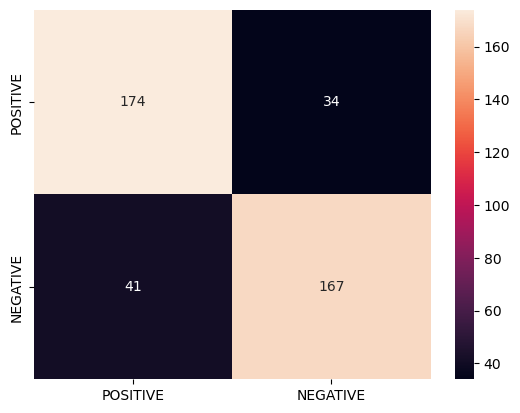

In [147]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib as plt

y_pred = clf.predict(test_x_vectors)

labels = [Sentiment.POSITIVE , Sentiment.NEGATIVE]

cm = confusion_matrix(test_y, y_pred, labels=labels)
df_cm = pd.DataFrame(cm, index=labels, columns=labels)

sn.heatmap(df_cm, annot=True, fmt='d')